In [1]:
from skimage import io
from skimage.data import astronaut
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv, hsv2rgb
import numpy as np
import cv2
from MyCannyEdgeDetectorDemo import myCannyEdgeDetector

In [2]:
# data=astronaut().astype(np.float32)
data=io.imread('images/captain.jpg').astype(np.float32)
img=np.transpose(data,(2,0,1))[:3,...] # transpose shape to (3,height,width) to fit my convolution function

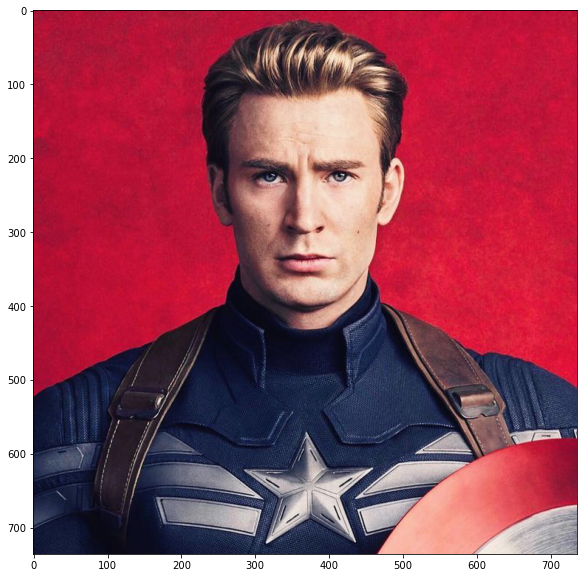

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(data.astype(np.uint8))
plt.show()

In [4]:
def get_gaussian_kernel(sigma, size=-1):
    if size < 0:
        size = int(1 + 2 * np.ceil(sigma * np.sqrt(np.log(400))))
    mid = size // 2
    kernel = np.zeros((size, 1))
    dkernel = np.zeros((size, 1))
    for i in range(size):
        kernel[i] = np.exp(-((i - mid) / sigma) ** 2 / 2)
    kernel = kernel
    return kernel

def img_padding(img, padding=0, padding_mode='zeros'):
    if isinstance(padding, int):
        padding = (0, 0)

    pad_width = [[0, 0] for _ in range(img.ndim)]
    pad_width[-2] = [padding[0], padding[0]]
    pad_width[-1] = [padding[1], padding[1]]
    if padding_mode == 'zeros':
        return np.pad(img, pad_width)
    elif padding_mode == 'reflect':
        return np.pad(img, pad_width, mode='reflect')
    elif padding_mode == 'replicate':
        return np.pad(img, pad_width, mode='symmetric')
    else:
        return NotImplemented

def my_bilateral_filter(img, d, sigma_s, sigma_r, padding_mode='zeros'):
    '''
    img: C*H*W, where C is channel (3 for rgb image, 1 for grayscale);
                  H and W are image height and width respectively.
    '''
    assert padding_mode in {'zeros', 'reflect', 'replicate'}, 'wrong padding mode'
    assert d & 1 == 1,'use odd number for d'
    kernel=get_gaussian_kernel(sigma_s,d)
    kernel=kernel@kernel.T

    kernel_size = kernel.shape
    h_k, w_k = kernel.shape  # kernel height and width
    padding = (h_k // 2, w_k // 2)

    if isinstance(padding, int):
        padding = (padding, padding)

    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)


    padded = img_padding(img, padding, padding_mode)

    C, H_in, W_in = img.shape  # batch size, rgb channel, Height, Width
    H_out = np.floor(H_in + 2 * padding[0] - kernel_size[0] + 1).astype(int)
    W_out = np.floor(W_in + 2 * padding[1] - kernel_size[1] + 1).astype(int)
    
    expanded = np.lib.stride_tricks.as_strided(
        padded,
        shape=(
            H_out,  # out channel height
            W_out,  # out channel width
            padded.shape[-3],  # input channel
            kernel.shape[-2],  # kernel height
            kernel.shape[-1],  # kernel width
        ),
        strides=(
            padded.strides[-2],  # H dimension
            padded.strides[-1],  # W dimension
            padded.strides[-3],  # input chennel
            padded.strides[-2],  # kernel height
            padded.strides[-1],  # kernel width
        ),
        writeable=False,
    )
    max_size=6e7
    HWmax=np.sqrt(max_size/h_k/w_k/C).astype(int)
    W=np.arange(HWmax,W_out,HWmax)
    W=np.append(W,W_out+1)
    H=np.arange(HWmax,H_out,HWmax)
    H=np.append(H,H_out+1)
    hi=0
    wi=0
    feature_map=np.zeros((H_out,W_out,C))
    for w in W:
        hi=0
        for h in H:
            part=expanded[hi:h,wi:w,...]
            
            color_dist=(part-part[...,[h_k // 2],[w_k // 2],None]).sum(axis=-3)
            
            gr=np.exp(-(color_dist/sigma_r)**2/2)
            Wp=(gr*kernel)
            Wp/=np.sum(Wp,axis=(-1,-2),keepdims=True)

            Wp=np.lib.stride_tricks.as_strided(
                Wp,
                shape=(*Wp.shape[:2],C,*Wp.shape[2:]),
                strides=(*Wp.strides[:2],0,*Wp.strides[2:]),
                writeable=False
            )
            feature_map[hi:h,wi:w]=np.einsum('...ij,...ij->...', part, Wp)
            hi=h
        wi=w
    return feature_map

#https://stackoverflow.com/questions/5000665/bilateral-filtering-with-color

In [5]:
%%time
result=my_bilateral_filter(img, d=15,sigma_s=100,sigma_r=100)

CPU times: user 2.8 s, sys: 694 ms, total: 3.49 s
Wall time: 3.5 s


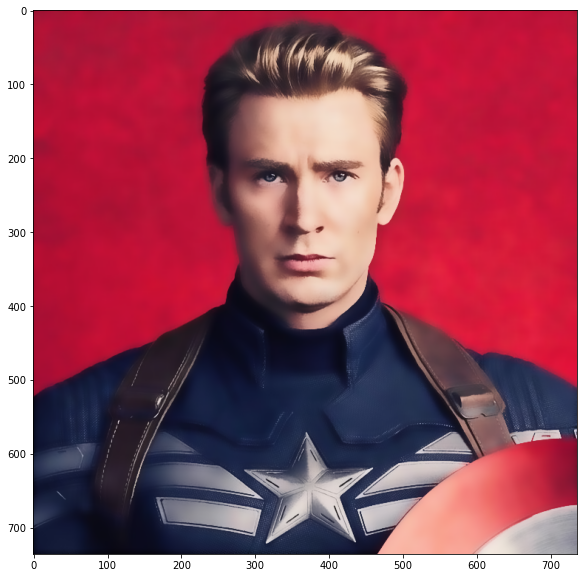

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(result.astype(np.uint8))
plt.show()

### enhance saturation

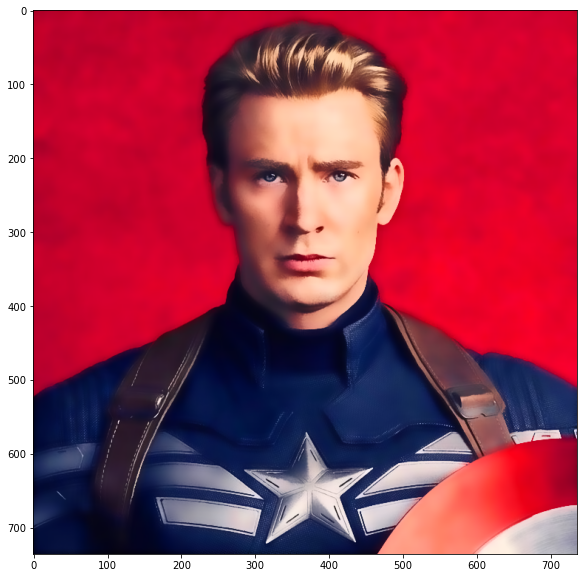

In [7]:
hsv_r = rgb2hsv(result/255) # hsv
hsv_r[...,1]*=1.4 #saturation
hsv_r[...,2]*=1.1 # value
hsv_r[...,1]=np.clip(hsv_r[...,1],0,1)
hsv_r[...,2]=np.clip(hsv_r[...,2],0,1)
result_ce=hsv2rgb(hsv_r)*255
plt.figure(figsize=(10,10))
plt.imshow(result_ce.astype(np.uint8))
plt.show()

### color quantization

In [8]:
def color_quantization(img,k):
    data=np.float32(img).reshape((-1,3))
    criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,20,0.001)
    ret,label,center=cv2.kmeans(data,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    center=np.uint8(center)
    result=center[label.flatten()]
    result=result.reshape(img.shape)
    return result

In [9]:
%%time
result_cq=color_quantization(result_ce,10)

CPU times: user 16.6 s, sys: 291 ms, total: 16.8 s
Wall time: 4.67 s


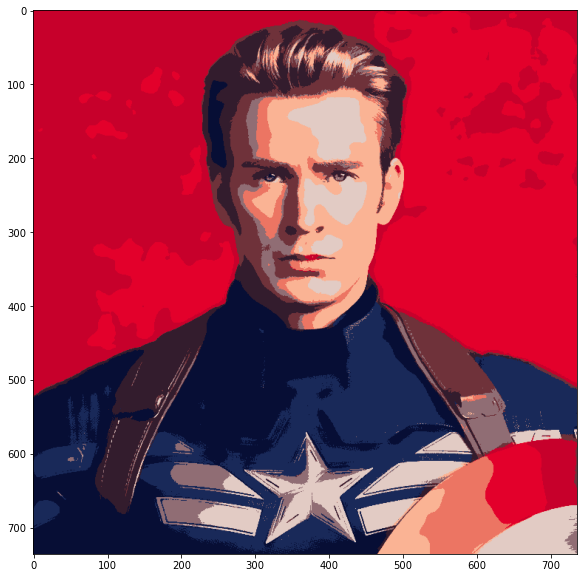

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(result_cq)
plt.show()

### edge detection
a tiny modification at non-max suppression so edges can have line width larger than 1.

In [12]:
%%time
# find edge from original image
my_edge = myCannyEdgeDetector(data, 0.1, 0.3,line_width=3)

CPU times: user 286 ms, sys: 40 µs, total: 286 ms
Wall time: 296 ms


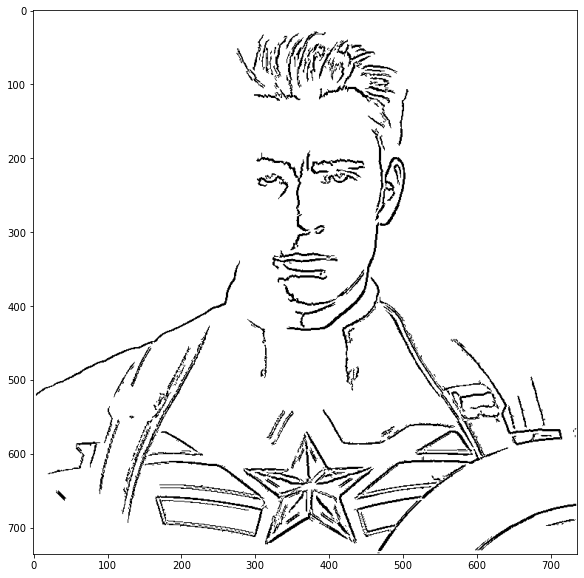

In [13]:
plt.figure(figsize=(10,10))
plt.imshow( ~my_edge, cmap='gray')
plt.show()

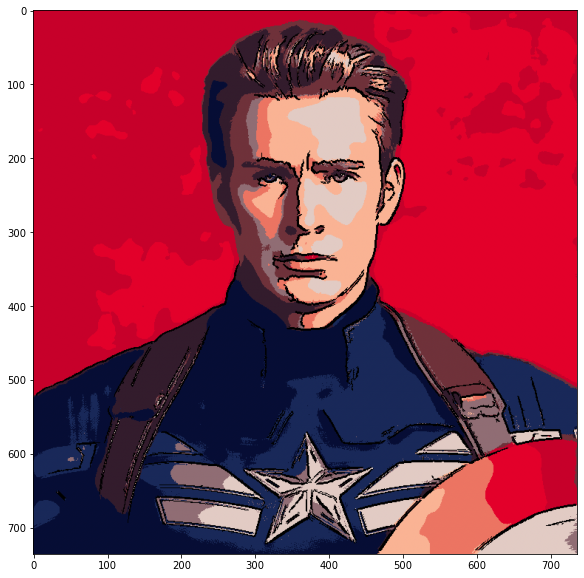

In [14]:
hsv_r = rgb2hsv(result_cq/255)
hsv_r[my_edge,2]=0
result_edge=hsv2rgb(hsv_r)
plt.figure(figsize=(10,10))
plt.imshow(result_edge)
plt.show()

In [15]:
from PIL import Image
im = Image.fromarray((result_edge*255).astype(np.uint8))
im.save('images/cartoon.jpg')